In [1]:
import numpy as np
from numpy import genfromtxt
import keras
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras import preprocessing
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import GRU, LSTM, CuDNNGRU, CuDNNLSTM
import matplotlib.pyplot as plt
%matplotlib inline


twitter_data = genfromtxt('/home/ubuntu/RNN_project/train.csv', delimiter=',', skip_header=1, usecols=np.arange(1,3), dtype=None, encoding="ISO-8859-1")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [130]:
size = len(twitter_data)
split1 = int(size*.8)
split2 = int(size*.9)

In [131]:
np.random.shuffle(twitter_data)

In [132]:
train = twitter_data[0:split1]
test = twitter_data[split1:split2]
validation = twitter_data[split2:size]

train_y = [y[0] for y in train]
#decode to convert from byte to string
train_x = [x[1] for x in train]

test_y = [y[0] for y in test]
test_x = [x[1]for x in test]

validation_y = [y[0] for y in validation]
validation_x = [x[1] for x in validation]


In [133]:
max_tokens = 1000
tokenizer = Tokenizer(num_words=max_tokens)
tokenizer.fit_on_texts(train_x)
sequences = tokenizer.texts_to_sequences(train_x)

#one_hot_results = tokenizer.texts_to_matrix(train_x, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 80841 unique tokens.


In [134]:
embedding_layer = Embedding(max_tokens, 8)

max_length = 140

train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)
validation_x = tokenizer.texts_to_sequences(validation_x)

train_x = preprocessing.sequence.pad_sequences(train_x, maxlen=max_length)
test_x = preprocessing.sequence.pad_sequences(test_x, maxlen=max_length)
validation_x = preprocessing.sequence.pad_sequences(validation_x, maxlen=max_length)

train_y = np.array(train_y)
test_y = np.array(test_y)
validation_y = np.array(validation_y)

In [135]:
print(train_x.shape, test_x.shape, validation_x.shape)

(80000, 140) (10000, 140) (10000, 140)


In [136]:
K.clear_session()
model = Sequential()
model.add(Embedding(max_tokens, 8, input_length=max_length))
#use this for local/cpu testing
model.add(GRU(16, recurrent_dropout=0.4, return_sequences=True))
model.add(GRU(8, recurrent_dropout=0.4, return_sequences=True))
#model.add(GRU(4, recurrent_dropout=0.2))
model.add(LSTM(8))
#use this for GPU
#model.add(CuDNNGRU(16, return_sequences=True))
#model.add(CuDNNLSTM(16))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 8)            8000      
_________________________________________________________________
gru_1 (GRU)                  (None, 140, 16)           1200      
_________________________________________________________________
gru_2 (GRU)                  (None, 140, 8)            600       
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 10,353
Trainable params: 10,353
Non-trainable params: 0
_________________________________________________________________


In [137]:
checkpoint = ModelCheckpoint('NLP_model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=5, min_lr=0.0001)

history = model.fit(train_x, train_y,
                    epochs=50,
                    batch_size=20000,
                    validation_data=(validation_x, validation_y),
                    callbacks=[checkpoint,reduce_lr])

Train on 80000 samples, validate on 10000 samples
Epoch 1/50
80000/80000 [==============================] - 8s 102us/step - loss: 0.6912 - acc: 0.5429 - val_loss: 0.6889 - val_acc: 0.5622
Epoch 2/50
80000/80000 [==============================] - 6s 79us/step - loss: 0.6870 - acc: 0.5654 - val_loss: 0.6849 - val_acc: 0.5622
Epoch 3/50
80000/80000 [==============================] - 6s 79us/step - loss: 0.6832 - acc: 0.5654 - val_loss: 0.6821 - val_acc: 0.5622
Epoch 4/50
80000/80000 [==============================] - 6s 79us/step - loss: 0.6804 - acc: 0.5654 - val_loss: 0.6790 - val_acc: 0.5622
Epoch 5/50
80000/80000 [==============================] - 6s 79us/step - loss: 0.6765 - acc: 0.5654 - val_loss: 0.6731 - val_acc: 0.5635
Epoch 6/50
80000/80000 [==============================] - 6s 79us/step - loss: 0.6689 - acc: 0.5822 - val_loss: 0.6625 - val_acc: 0.6067
Epoch 7/50
80000/80000 [==============================] - 6s 79us/step - loss: 0.6565 - acc: 0.6248 - val_loss: 0.6468 - val_ac

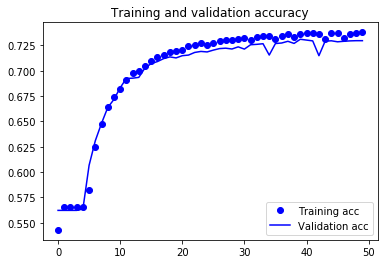

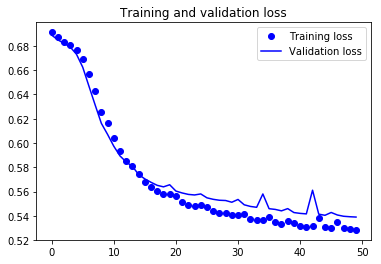

In [138]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [139]:
model.evaluate(test_x, test_y)

10000/10000 [==============================] - 32s 3ms/step


[0.5417143960952758, 0.7284]

In [140]:
model.save('NLP_model.h5')